In [57]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import seaborn as sns
pd.set_option('display.max_rows', 250)

In [58]:
!cd ..;python parse_tb.py

In [59]:
res_df = pd.read_csv('../results/ar-v3.csv')

In [60]:
res_df['num_layers'] = 1
res_df.loc[res_df.model_path.apply(lambda x: '2l2h' in x), 'num_layers'] = 2
res_df.loc[res_df.model_path.apply(lambda x: '4l4h' in x), 'num_layers'] = 4
# res_df.loc[res_df.model_path.apply(lambda x: '8l8h' in x), 'num_layers'] = 8

In [61]:
res_df.columns

Index(['task_name', 'from_pretrained', 'model_cfg', 'model_cls', 'model_type',
       'lr', 'batch_size', 'lr_scheduler', 'max_n_segments', 'input_size',
       'num_mem_tokens', 'model_path', 'num_steps', 'best_valid_exact_match',
       'key_size', 'value_size', 'num_pairs', 'num_layers'],
      dtype='object')

### From checkpoint

In [62]:
df = res_df[res_df.model_path.apply(lambda x: 'from_cpt' in x)]

gb_cols = ['max_n_segments', 'num_mem_tokens', 'key_size', 'value_size']
metric_cols = ['best_valid_exact_match']
group_df = df.groupby(gb_cols).max()[metric_cols]
group_df['std'] = df.groupby(gb_cols)[metric_cols].std()
group_df['n_runs'] = df.groupby(gb_cols)[metric_cols].count()
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

,,,,best_valid_exact_match,std,n_runs,runs
max_n_segments,num_mem_tokens,key_size,value_size,,,,


### From scratch

In [63]:
res_df['dim'] = 128
res_df.loc[res_df.model_path.apply(lambda x: 'd256' in x), 'dim'] = 256

In [67]:
df = res_df[res_df.model_path.apply(lambda x: 'from_cpt' not in x)].copy()

df = df[df.num_steps > 5000]

# gb_cols = ['max_n_segments', 'num_mem_tokens', 'key_size', 'value_size', 'lr', 'num_layers']
# gb_cols = ['max_n_segments',  'num_layers', 'dim', 'num_mem_tokens', 'key_size', 'value_size', 'lr']
gb_cols = ['max_n_segments',  'num_layers', 'dim', 'num_mem_tokens', 'key_size', 'value_size']
metric_cols = ['best_valid_exact_match']
group_df = df.groupby(gb_cols).max()[metric_cols]
group_df['std'] = df.groupby(gb_cols)[metric_cols].std()
group_df['n_runs'] = df.groupby(gb_cols)[metric_cols].count()
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
# group_df

In [68]:
gdf = group_df.reset_index()

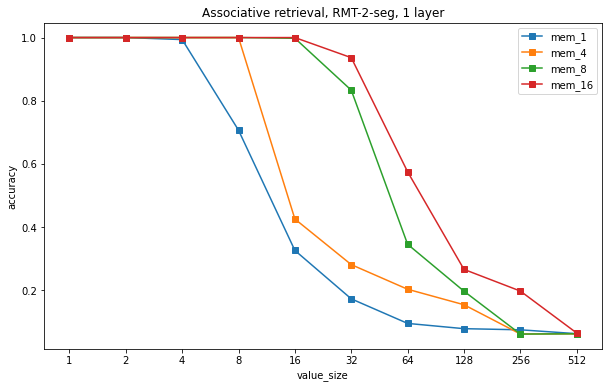

In [92]:
plt.figure(figsize=(10, 6))
plt.title('Associative retrieval, RMT-2-seg, 1 layer')
num_layers = 1

slc = gdf[gdf.num_layers == num_layers]

# mem_sizes = np.unique(slc.num_mem_tokens)
mem_sizes = [1, 4, 8, 16]

for mem_size in mem_sizes:
    slc_ = slc[slc.num_mem_tokens == mem_size]
    plt.plot(slc_.value_size, slc_.best_valid_exact_match, marker='s')
    
plt.legend([f'mem_{ms}' for ms in mem_sizes])
plt.xlabel('value_size')
plt.xscale('log', base=2)
plt.xticks(slc_.value_size, labels=slc_.value_size)

plt.ylabel('accuracy')
plt.show()

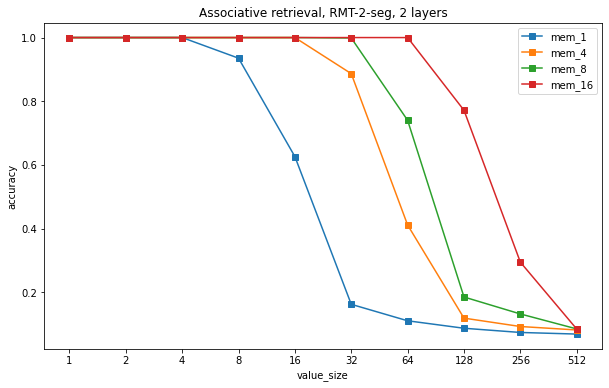

In [93]:
plt.figure(figsize=(10, 6))
plt.title('Associative retrieval, RMT-2-seg, 2 layers')
num_layers = 2

slc = gdf[gdf.num_layers == num_layers]

# mem_sizes = np.unique(slc.num_mem_tokens)
mem_sizes = [1, 4, 8, 16]

for mem_size in mem_sizes:
    slc_ = slc[slc.num_mem_tokens == mem_size]
    plt.plot(slc_.value_size, slc_.best_valid_exact_match, marker='s')
    
plt.legend([f'mem_{ms}' for ms in mem_sizes])
plt.xlabel('value_size')
plt.xscale('log', base=2)
plt.xticks(slc_.value_size, labels=slc_.value_size)

plt.ylabel('accuracy')
plt.show()

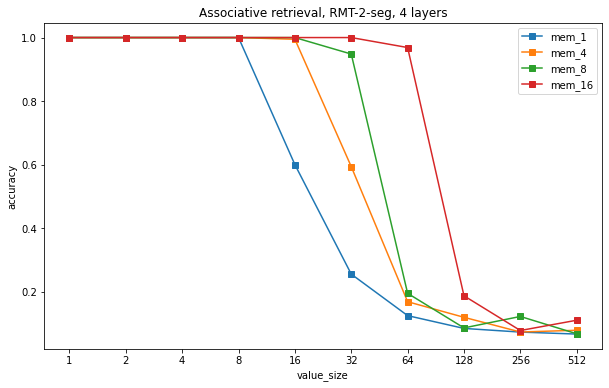

In [94]:
plt.figure(figsize=(10, 6))
plt.title('Associative retrieval, RMT-2-seg, 4 layers')
num_layers = 4

slc = gdf[gdf.num_layers == num_layers]

# mem_sizes = np.unique(slc.num_mem_tokens)
mem_sizes = [1, 4, 8, 16]

for mem_size in mem_sizes:
    slc_ = slc[slc.num_mem_tokens == mem_size]
    plt.plot(slc_.value_size, slc_.best_valid_exact_match, marker='s')
    
plt.legend([f'mem_{ms}' for ms in mem_sizes])
plt.xlabel('value_size')
plt.xscale('log', base=2)
plt.xticks(slc_.value_size, labels=slc_.value_size)

plt.ylabel('accuracy')
plt.show()

In [141]:
slc = gdf[gdf.best_valid_exact_match == 1]

slc = slc[slc.num_mem_tokens != 2]
# slc.head()
gb = slc.groupby(['num_mem_tokens', 'num_layers']).max('value_size')['value_size'].reset_index()

In [166]:
table

value_size        
num_layers              1   2   4
num_mem_tokens                   
1                       2   4   8
4                       8  16   8
8                       8  16  16
16                     16  32  32

In [164]:
table.index

Int64Index([1, 4, 8, 16], dtype='int64', name='num_mem_tokens')

In [169]:
table.mul(1 / table.index, axis=0).astype(int)

value_size      
num_layers              1  2  4
num_mem_tokens                 
1                       2  4  8
4                       2  4  2
8                       1  2  2
16                      1  2  2

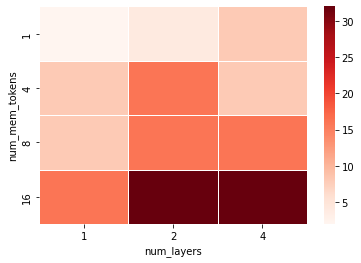

In [159]:
table = pd.pivot_table(gb, index=['num_mem_tokens'], columns=['num_layers'], values=['value_size'])
# plt.imshow(table)
sns.heatmap(table.values, linewidth=0.5, cmap='Reds')
plt.xlabel('num_layers')
plt.ylabel('num_mem_tokens')

plt.xticks([0.5, 1.5, 2.5], labels=[1, 2, 4])
plt.yticks([0.5, 1.5, 2.5, 3.5], labels=[1, 4, 8, 16])
plt.title('How many tokens can 1 memory token hold?')
plt.show()

In [ ]:
mem_sizes = [1, 4, 8, 16]

num_layers = [1, 2, 4]

np.unique(gdf.num_mem_tokens)

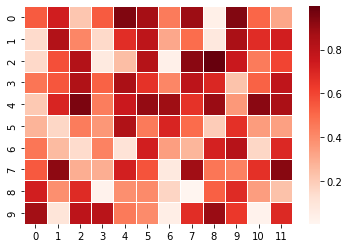

In [114]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(uniform_data, linewidth=0.5, cmap='Reds')
plt.show()

### plot

In [18]:
df = res_df[res_df.model_path.apply(lambda x: 'from_cpt' not in x)].copy()

df = df[df.lr == 0.0001]
# df = df[df.num_layers == 1]
df = df[df.num_steps > 5000]



# gb_cols = ['max_n_segments', 'num_mem_tokens', 'key_size', 'value_size', 'lr', 'num_layers']
gb_cols = [ 'max_n_segments',  'num_layers','key_size', 'value_size',  'num_mem_tokens']
metric_cols = ['best_valid_exact_match']
group_df = df.groupby(gb_cols)[metric_cols].mean()[metric_cols]
group_df['std'] = df.groupby(gb_cols)[metric_cols].std()
group_df['n_runs'] = df.groupby(gb_cols)[metric_cols].count()
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
# group_df

In [19]:
# plt.title('Associative retrieval, K=4, 1L1H')

# gb = group_df.reset_index()
# gb = gb[gb.num_layers == 1]
# gb = gb[(gb.value_size > 1) & (gb.value_size < 16)]
# value_sizes = np.unique(gb.value_size)
# for vs in value_sizes:
#     slc = gb[gb.value_size == vs]
#     plt.plot(slc.num_mem_tokens, slc.best_valid_exact_match, marker='o')

# plt.xticks(gb.num_mem_tokens.unique())
# plt.xlabel('Memory size')
# plt.ylabel('accuracy')
# plt.legend([f'value size {vs}' for vs in value_sizes])
# plt.show()

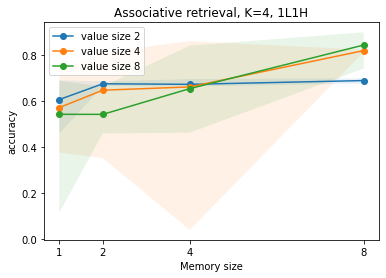

In [22]:
mask = (df.max_n_segments == 2) & (df.num_layers == 1) & (df.value_size > 1) & (df.value_size < 16) & (df.lr == 0.0001) & (df.num_steps > 5000)
selected = df[mask]

value_sizes = np.unique(selected.value_size)

for vs in value_sizes:
    slc = selected[selected.value_size == vs]
    gb = slc.groupby('num_mem_tokens').agg({'best_valid_exact_match': tuple})
    means = gb.best_valid_exact_match.apply(np.mean)
    plt.plot(means, marker='o')
    # plt.fill_between(means.index, mins.values, maxs.values, alpha=0.2)
    
for vs in value_sizes:
    slc = selected[selected.value_size == vs]
    gb = slc.groupby('num_mem_tokens').agg({'best_valid_exact_match': tuple})
    maxs = gb.best_valid_exact_match.apply(np.max)
    mins = gb.best_valid_exact_match.apply(np.min)
    means = gb.best_valid_exact_match.apply(np.mean)
    plt.fill_between(means.index, mins.values, maxs.values, alpha=0.1)
    
plt.title('Associative retrieval, K=4, 1L1H')
plt.xticks(gb.index.unique())
plt.xlabel('Memory size')
plt.ylabel('accuracy')
plt.legend([f'value size {vs}' for vs in value_sizes])
plt.show()

In [147]:
# plt.title('Associative retrieval, K=4, 2L2H')

# gb = group_df.reset_index()
# gb = gb[gb.num_layers == 2]
# gb = gb[gb.value_size > 1]
# value_sizes = np.unique(gb.value_size)
# for vs in value_sizes:
#     slc = gb[gb.value_size == vs]
#     plt.plot(slc.num_mem_tokens, slc.best_valid_exact_match, marker='o')

# plt.xticks(gb.num_mem_tokens.unique())
# plt.xlabel('Memory size')
# plt.ylabel('accuracy')
# plt.legend([f'value size {vs}' for vs in value_sizes])
# plt.show()

### By task

### K4V4

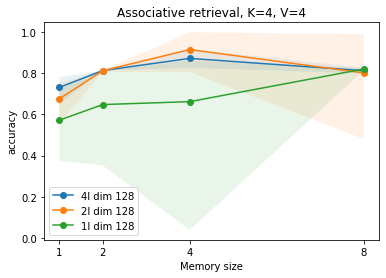

In [40]:
mask = (df.max_n_segments == 2) & (df.value_size == 4)  & (df.lr == 0.0001) & (df.dim == 128) & (df.num_steps > 5000)
selected = df[mask]

nls = np.unique(selected.num_layers)[::-1]

for nl in nls:
    slc = selected[selected.num_layers == nl]
    gb = slc.groupby('num_mem_tokens').agg({'best_valid_exact_match': tuple})
    means = gb.best_valid_exact_match.apply(np.mean)
    plt.plot(means, marker='o')
    # plt.fill_between(means.index, mins.values, maxs.values, alpha=0.2)
    
for nl in nls:
    slc = selected[selected.num_layers == nl]
    gb = slc.groupby('num_mem_tokens').agg({'best_valid_exact_match': tuple})
    maxs = gb.best_valid_exact_match.apply(np.max)
    mins = gb.best_valid_exact_match.apply(np.min)
    means = gb.best_valid_exact_match.apply(np.mean)
    plt.fill_between(means.index, mins.values, maxs.values, alpha=0.1)
    
plt.title('Associative retrieval, K=4, V=4')
plt.xticks(gb.index.unique())
plt.xlabel('Memory size')
plt.ylabel('accuracy')
plt.legend([f'{nl}l dim 128' for nl in nls])
plt.show()

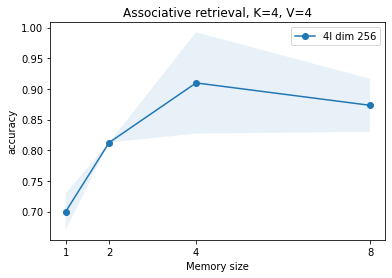

In [41]:
mask = (df.max_n_segments == 2) & (df.value_size == 4)  & (df.lr == 0.0001) & (df.dim == 256) & (df.num_steps > 5000)
selected = df[mask]

nls = np.unique(selected.num_layers)

for nl in nls:
    slc = selected[selected.num_layers == nl]
    gb = slc.groupby('num_mem_tokens').agg({'best_valid_exact_match': tuple})
    means = gb.best_valid_exact_match.apply(np.mean)
    plt.plot(means, marker='o')
    # plt.fill_between(means.index, mins.values, maxs.values, alpha=0.2)
    
for nl in nls:
    slc = selected[selected.num_layers == nl]
    gb = slc.groupby('num_mem_tokens').agg({'best_valid_exact_match': tuple})
    maxs = gb.best_valid_exact_match.apply(np.max)
    mins = gb.best_valid_exact_match.apply(np.min)
    means = gb.best_valid_exact_match.apply(np.mean)
    plt.fill_between(means.index, mins.values, maxs.values, alpha=0.1)
    
plt.title('Associative retrieval, K=4, V=4')
plt.xticks(gb.index.unique())
plt.xlabel('Memory size')
plt.ylabel('accuracy')
plt.legend([f'{nl}l dim 256' for nl in nls])
plt.show()

### K4V8

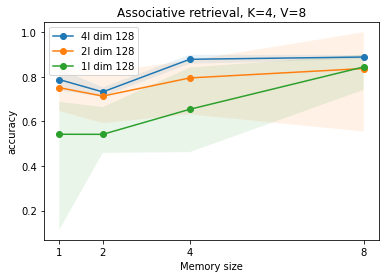

In [44]:
mask = (df.max_n_segments == 2) & (df.value_size == 8)  & (df.lr == 0.0001) & (df.dim == 128) & (df.num_steps > 5000)
selected = df[mask]

nls = np.unique(selected.num_layers)[::-1]

for nl in nls:
    slc = selected[selected.num_layers == nl]
    gb = slc.groupby('num_mem_tokens').agg({'best_valid_exact_match': tuple})
    means = gb.best_valid_exact_match.apply(np.mean)
    plt.plot(means, marker='o')
    # plt.fill_between(means.index, mins.values, maxs.values, alpha=0.2)
    
for nl in nls:
    slc = selected[selected.num_layers == nl]
    gb = slc.groupby('num_mem_tokens').agg({'best_valid_exact_match': tuple})
    maxs = gb.best_valid_exact_match.apply(np.max)
    mins = gb.best_valid_exact_match.apply(np.min)
    means = gb.best_valid_exact_match.apply(np.mean)
    plt.fill_between(means.index, mins.values, maxs.values, alpha=0.1)
    
plt.title('Associative retrieval, K=4, V=8')
plt.xticks(gb.index.unique())
plt.xlabel('Memory size')
plt.ylabel('accuracy')
plt.legend([f'{nl}l dim 128' for nl in nls])
plt.show()

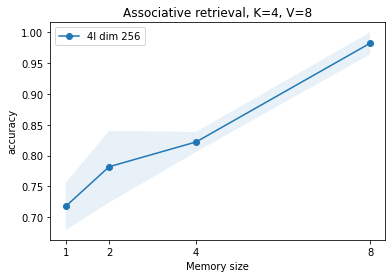

In [45]:
mask = (df.max_n_segments == 2) & (df.value_size == 8)  & (df.lr == 0.0001) & (df.dim == 256) & (df.num_steps > 5000)
selected = df[mask]

nls = np.unique(selected.num_layers)

for nl in nls:
    slc = selected[selected.num_layers == nl]
    gb = slc.groupby('num_mem_tokens').agg({'best_valid_exact_match': tuple})
    means = gb.best_valid_exact_match.apply(np.mean)
    plt.plot(means, marker='o')
    # plt.fill_between(means.index, mins.values, maxs.values, alpha=0.2)
    
for nl in nls:
    slc = selected[selected.num_layers == nl]
    gb = slc.groupby('num_mem_tokens').agg({'best_valid_exact_match': tuple})
    maxs = gb.best_valid_exact_match.apply(np.max)
    mins = gb.best_valid_exact_match.apply(np.min)
    means = gb.best_valid_exact_match.apply(np.mean)
    plt.fill_between(means.index, mins.values, maxs.values, alpha=0.1)
    
plt.title('Associative retrieval, K=4, V=8')
plt.xticks(gb.index.unique())
plt.xlabel('Memory size')
plt.ylabel('accuracy')
plt.legend([f'{nl}l dim 256' for nl in nls])
plt.show()

### By model

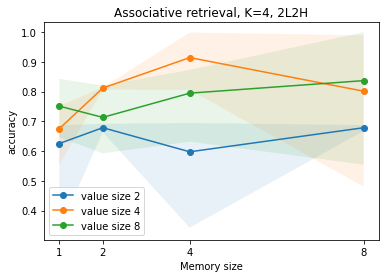

In [23]:
mask = (df.max_n_segments == 2) & (df.num_layers == 2) & (df.value_size > 1) & (df.value_size < 16) & (df.lr == 0.0001) & (df.num_steps > 5000)
selected = df[mask]

value_sizes = np.unique(selected.value_size)

for vs in value_sizes:
    slc = selected[selected.value_size == vs]
    gb = slc.groupby('num_mem_tokens').agg({'best_valid_exact_match': tuple})
    means = gb.best_valid_exact_match.apply(np.mean)
    plt.plot(means, marker='o')
    # plt.fill_between(means.index, mins.values, maxs.values, alpha=0.2)
    
for vs in value_sizes:
    slc = selected[selected.value_size == vs]
    gb = slc.groupby('num_mem_tokens').agg({'best_valid_exact_match': tuple})
    maxs = gb.best_valid_exact_match.apply(np.max)
    mins = gb.best_valid_exact_match.apply(np.min)
    means = gb.best_valid_exact_match.apply(np.mean)
    plt.fill_between(means.index, mins.values, maxs.values, alpha=0.1)
    
plt.title('Associative retrieval, K=4, 2L2H')
plt.xticks(gb.index.unique())
plt.xlabel('Memory size')
plt.ylabel('accuracy')
plt.legend([f'value size {vs}' for vs in value_sizes])
plt.show()

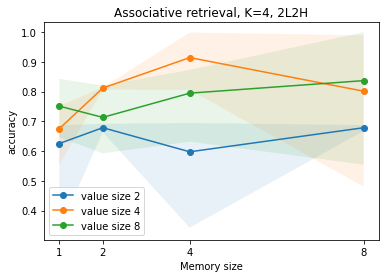

In [24]:
mask = (df.max_n_segments == 2) & (df.num_layers == 2) & (df.value_size > 1) & (df.value_size < 16) & (df.lr == 0.0001) & (df.num_steps > 5000)
selected = df[mask]

value_sizes = np.unique(selected.value_size)

for vs in value_sizes:
    slc = selected[selected.value_size == vs]
    gb = slc.groupby('num_mem_tokens').agg({'best_valid_exact_match': tuple})
    means = gb.best_valid_exact_match.apply(np.mean)
    plt.plot(means, marker='o')
    # plt.fill_between(means.index, mins.values, maxs.values, alpha=0.2)
    
for vs in value_sizes:
    slc = selected[selected.value_size == vs]
    gb = slc.groupby('num_mem_tokens').agg({'best_valid_exact_match': tuple})
    maxs = gb.best_valid_exact_match.apply(np.max)
    mins = gb.best_valid_exact_match.apply(np.min)
    means = gb.best_valid_exact_match.apply(np.mean)
    plt.fill_between(means.index, mins.values, maxs.values, alpha=0.1)
    
plt.title('Associative retrieval, K=4, 2L2H')
plt.xticks(gb.index.unique())
plt.xlabel('Memory size')
plt.ylabel('accuracy')
plt.legend([f'value size {vs}' for vs in value_sizes])
plt.show()

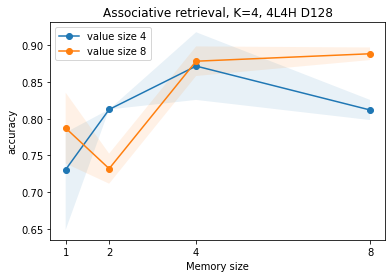

In [30]:
mask = (df.max_n_segments == 2) & (df.dim == 128) & (df.num_layers == 4) & (df.value_size > 2) & (df.value_size < 16) & (df.lr == 0.0001) & (df.num_steps > 5000)
selected = df[mask]

value_sizes = np.unique(selected.value_size)

for vs in value_sizes:
    slc = selected[selected.value_size == vs]
    gb = slc.groupby('num_mem_tokens').agg({'best_valid_exact_match': tuple})
    means = gb.best_valid_exact_match.apply(np.mean)
    plt.plot(means, marker='o')
    # plt.fill_between(means.index, mins.values, maxs.values, alpha=0.2)
    
for vs in value_sizes:
    slc = selected[selected.value_size == vs]
    gb = slc.groupby('num_mem_tokens').agg({'best_valid_exact_match': tuple})
    maxs = gb.best_valid_exact_match.apply(np.max)
    mins = gb.best_valid_exact_match.apply(np.min)
    means = gb.best_valid_exact_match.apply(np.mean)
    plt.fill_between(means.index, mins.values, maxs.values, alpha=0.1)
    
plt.title('Associative retrieval, K=4, 4L4H D128')
plt.xticks(gb.index.unique())
plt.xlabel('Memory size')
plt.ylabel('accuracy')
plt.legend([f'value size {vs}' for vs in value_sizes])
plt.show()

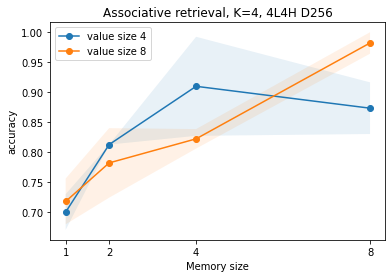

In [29]:
mask = (df.max_n_segments == 2) & (df.dim == 256) & (df.num_layers == 4) & (df.value_size > 2) & (df.value_size < 16) & (df.lr == 0.0001) & (df.num_steps > 5000)
selected = df[mask]

value_sizes = np.unique(selected.value_size)

for vs in value_sizes:
    slc = selected[selected.value_size == vs]
    gb = slc.groupby('num_mem_tokens').agg({'best_valid_exact_match': tuple})
    means = gb.best_valid_exact_match.apply(np.mean)
    plt.plot(means, marker='o')
    # plt.fill_between(means.index, mins.values, maxs.values, alpha=0.2)
    
for vs in value_sizes:
    slc = selected[selected.value_size == vs]
    gb = slc.groupby('num_mem_tokens').agg({'best_valid_exact_match': tuple})
    maxs = gb.best_valid_exact_match.apply(np.max)
    mins = gb.best_valid_exact_match.apply(np.min)
    means = gb.best_valid_exact_match.apply(np.mean)
    plt.fill_between(means.index, mins.values, maxs.values, alpha=0.1)
    
plt.title('Associative retrieval, K=4, 4L4H D256')
plt.xticks(gb.index.unique())
plt.xlabel('Memory size')
plt.ylabel('accuracy')
plt.legend([f'value size {vs}' for vs in value_sizes])
plt.show()

In [91]:
res_df.num_mem_tokens = res_df.num_mem_tokens.fillna('NA')
res_df.max_n_segments = res_df.max_n_segments.fillna('NA')
# res_df.k2 = res_df.k2.fillna(-1)
res_df['checkpoint_segment'] = res_df.model_path.apply(lambda x: x.split('from_cpt_')[1].split('-')[0] if 'from_cpt_' in x else -1).astype(int)
res_df['eval_segment'] = res_df.max_n_segments

# res_df = res_df[res_df.best_valid_exact_match > 0]

res_df_c = res_df[res_df.checkpoint_segment != -1]
res_df = res_df[res_df.checkpoint_segment == -1]
# noise_df = res_df[res_df.model_path.apply(lambda x: 'noise' in x)]
# res_df = res_df[res_df.model_path.apply(lambda x: 'noise' not in x)]

### regular

In [92]:
df = res_df[res_df.best_valid_exact_match > 0]

gb_cols = ['input_size', 'max_n_segments', 'num_mem_tokens']
metric_cols = ['best_valid_exact_match']
group_df = df.groupby(gb_cols).max()[metric_cols]
group_df['std'] = df.groupby(gb_cols)[metric_cols].std()
group_df['n_runs'] = df.groupby(gb_cols)[metric_cols].count()
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_exact_match  std  n_runs  \
input_size max_n_segments num_mem_tokens                                        
128        1              10.0                          0.635577  NaN       1   
           2              10.0                          0.538462  NaN       1   
           3              10.0                          0.501923  NaN       1   

                                            runs  
input_size max_n_segments num_mem_tokens          
128        1              10.0            [0.64]  
           2              10.0            [0.54]  
           3              10.0             [0.5]

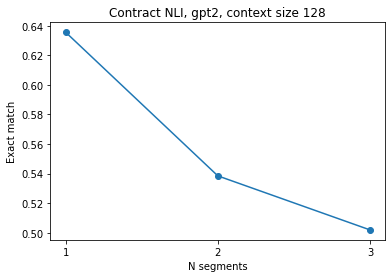

In [84]:
xs, ys = group_df.reset_index().max_n_segments, group_df.best_valid_exact_match
plt.plot(xs, ys, marker='o')
plt.xticks(xs)
# plt.yticks(ys)
plt.title('Contract NLI, gpt2, context size 128')
plt.xlabel('N segments')
plt.ylabel('Exact match')
plt.show()

In [87]:
df = res_df[res_df.num_mem_tokens == 5]
gb_cols = ['input_size', 'max_n_segments', 'num_mem_tokens']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols)[metric_cols].std()
group_df['n_runs'] = df.groupby(gb_cols)[metric_cols].count()
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_loss      std  n_runs  \
input_size max_n_segments num_mem_tokens                                     
128        1              5.0                    0.056818      NaN       1   
           2              5.0                    0.116341      NaN       1   
           3              5.0                    0.304654  0.09138       2   

                                                 runs  
input_size max_n_segments num_mem_tokens               
128        1              5.0                  [0.06]  
           2              5.0                  [0.12]  
           3              5.0             [0.3, 0.43]

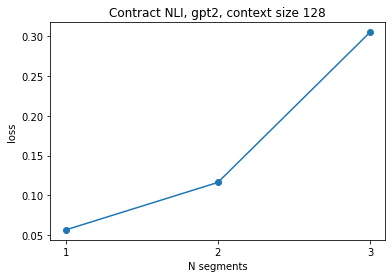

In [88]:
xs, ys = group_df.reset_index().max_n_segments, group_df.best_valid_loss
plt.plot(xs, ys, marker='o')
plt.xticks(xs)
# plt.yticks(ys)
plt.title('Contract NLI, gpt2, context size 128')
plt.xlabel('N segments')
plt.ylabel('loss')
plt.show()

### curriculum

In [75]:
df = res_df_c
gb_cols = ['input_size', 'max_n_segments', 'num_mem_tokens']
metric_cols = ['best_valid_exact_match']
group_df = df.groupby(gb_cols).max()[metric_cols]
group_df['std'] = df.groupby(gb_cols)[metric_cols].std()
group_df['n_runs'] = df.groupby(gb_cols)[metric_cols].count()
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_exact_match  std  n_runs  \
input_size max_n_segments num_mem_tokens                                        
128        1              5.0                           0.639423  NaN       1   
           2              5.0                           0.535577  NaN       1   
           3              5.0                           0.523077  NaN       1   
           4              5.0                           0.519231  NaN       1   
           5              5.0                           0.499038  NaN       1   
           6              5.0                           0.533654  NaN       1   
           7              5.0                           0.411538  NaN       1   

                                            runs  
input_size max_n_segments num_mem_tokens          
128        1              5.0             [0.64]  
           2              5.0             [0.54]  
           3              5.0             [0.52]  
           4              5.0             [0.52]  
           5              5.0              [0.5]  
           6              5.0             [0.53]  
           7              5.0             [0.41]

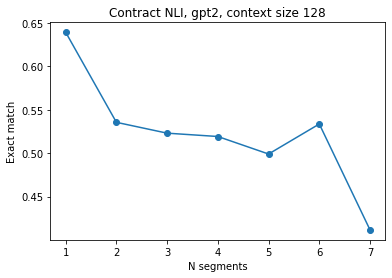

In [76]:
xs, ys = group_df.reset_index().max_n_segments, group_df.best_valid_exact_match
plt.plot(xs, ys, marker='o')
plt.xticks(xs)
# plt.yticks(ys)
plt.title('Contract NLI, gpt2, context size 128')
plt.xlabel('N segments')
plt.ylabel('Exact match')
plt.show()

In [77]:
df = res_df_c
gb_cols = ['input_size', 'max_n_segments', 'num_mem_tokens']
metric_cols = ['best_valid_loss']

group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['loss_std'] = df.groupby(gb_cols)[metric_cols].std()
group_df['n_runs'] = df.groupby(gb_cols)[metric_cols].count()
group_df['losses'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

metric_cols = ['best_valid_exact_match']
group_df['em']= df.groupby(gb_cols).max()[metric_cols][metric_cols[0]]
group_df['em_std'] = df.groupby(gb_cols)[metric_cols].std()
group_df['ems'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])




group_df

best_valid_loss  loss_std  n_runs  \
input_size max_n_segments num_mem_tokens                                      
128        1              5.0                    0.051865       NaN       1   
           2              5.0                    0.052384       NaN       1   
           3              5.0                    0.049465       NaN       1   
           4              5.0                    0.054000       NaN       1   
           5              5.0                    0.045120       NaN       1   
           6              5.0                    0.043461       NaN       1   
           7              5.0                    0.048393       NaN       1   

                                          losses        em  em_std     ems  
input_size max_n_segments num_mem_tokens                                    
128        1              5.0             [0.05]  0.639423     NaN  [0.64]  
           2              5.0             [0.05]  0.535577     NaN  [0.54]  
           3              5.0             [0.05]  0.523077     NaN  [0.52]  
           4              5.0             [0.05]  0.519231     NaN  [0.52]  
           5              5.0             [0.05]  0.499038     NaN   [0.5]  
           6              5.0             [0.04]  0.533654     NaN  [0.53]  
           7              5.0             [0.05]  0.411538     NaN  [0.41]

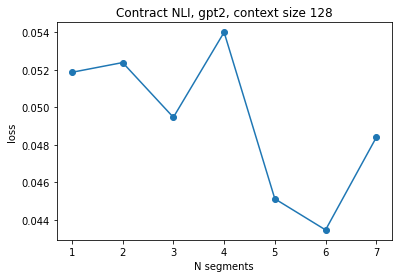

In [78]:
xs, ys = group_df.reset_index().max_n_segments, group_df.best_valid_loss
plt.plot(xs, ys, marker='o')
plt.xticks(xs)
# plt.yticks(ys)
plt.title('Contract NLI, gpt2, context size 128')
plt.xlabel('N segments')
plt.ylabel('loss')
plt.show()

### noise lm training

In [ ]:
noise_df = noise_df[noise_df.model_path.apply(lambda x: 'eval' in x)]
noise_df['noise_segments'] = noise_df.model_path.apply(lambda x: x.split('eval_noise-')[1].split('/run')[0]).astype(int)
noise_df['noise_segments_train'] = noise_df.model_path.apply(lambda x: x.split('_eval_noise-')[0].split('noise-')[1] if 'noise' in x.split('eval_noise-')[0] else 0).astype(int)

df = noise_df
gb_cols = ['input_size', 'checkpoint_segment', 'noise_segments_train', 'eval_segment', 'noise_segments']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_loss  \
input_size checkpoint_segment noise_segments_train eval_segment noise_segments                    
128        3                  0                    3            1                      2.269891   
                                                                2                      2.586574   
           4                  0                    4            1                      2.174744   
                                                                2                      2.301116   
                                                                3                      2.606908   
                              2                    4            1                      2.176340   
                                                                2                      2.299838   
                                                                3                      2.608539   
           5                  0                    5            1                      1.940996   
                                                                2                      2.016516   
                                                                3                      2.148022   
                                                                4                      2.520535   

                                                                                     std  \
input_size checkpoint_segment noise_segments_train eval_segment noise_segments             
128        3                  0                    3            1                    NaN   
                                                                2                    NaN   
           4                  0                    4            1               0.000045   
                                                                2                    NaN   
                                                                3                    NaN   
                              2                    4            1                    NaN   
                                                                2                    NaN   
                                                                3                    NaN   
           5                  0                    5            1                    NaN   
                                                                2                    NaN   
                                                                3                    NaN   
                                                                4                    NaN   

                                                                                n_runs  \
input_size checkpoint_segment noise_segments_train eval_segment noise_segments           
128        3                  0                    3            1                    1   
                                                                2                    1   
           4                  0                    4            1                    2   
                                                                2                    1   
                                                                3                    1   
                              2                    4            1                    1   
                                                                2                    1   
                                                                3                    1   
           5                  0                    5            1                    1   
                                                                2                    1   
                                                                3                    1   
                                                                4                    1   

                                                                                        runs  
input_size checkpoint_segment noise_segments_tra

In [105]:
df = noise_df
gb_cols = ['input_size', 'checkpoint_segment', 'noise_segments_train', 'eval_segment', 'noise_segments']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_loss  \
input_size checkpoint_segment noise_segments_train eval_segment noise_segments                    
128        3                  0                    3            1                      2.269891   
                                                                2                      2.586574   
           4                  0                    4            1                      2.174744   
                                                                2                      2.301116   
                                                                3                      2.606908   
                              2                    4            1                      2.176340   
                                                                2                      2.299838   
                                                                3                      2.608539   

                                                                                     std  \
input_size checkpoint_segment noise_segments_train eval_segment noise_segments             
128        3                  0                    3            1                    NaN   
                                                                2                    NaN   
           4                  0                    4            1               0.000045   
                                                                2                    NaN   
                                                                3                    NaN   
                              2                    4            1                    NaN   
                                                                2                    NaN   
                                                                3                    NaN   

                                                                                n_runs  \
input_size checkpoint_segment noise_segments_train eval_segment noise_segments           
128        3                  0                    3            1                    1   
                                                                2                    1   
           4                  0                    4            1                    2   
                                                                2                    1   
                                                                3                    1   
                              2                    4            1                    1   
                                                                2                    1   
                                                                3                    1   

                                                                                        runs  
input_size checkpoint_segment noise_segments_train eval_segment noise_segments                
128        3                  0                    3            1                     [2.27]  
                                                                2                     [2.59]  
           4                  0                    4            1               [2.17, 2.17]  
                                                                2                      [2.3]  
                                                                3                     [2.61]  
                              2                    4            1                     [2.18]  
                                                                2                      [2.3]  
                                                                3                     [2.61]

### mem2

In [44]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x)].copy()
df = df[df.num_mem_tokens == 2]

gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

# baseline_score = 2.953460
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table

best_valid_loss                                          \
eval_segment                     1         2         3         4         5   
checkpoint_segment                                                           
1                         2.384360  2.636101  2.537888  2.647668  2.620016   
2                         2.391469  2.222206  2.319046  2.305033  2.335198   
3                         2.409032  2.284900  2.175297  2.198428  2.226619   

                                                           
eval_segment               6         7        8         9  
checkpoint_segment                                         
1                   2.655133  2.629876  2.65116  2.634624  
2                   2.322438       NaN      NaN       NaN  
3                   2.249361       NaN      NaN       NaN

### mem5

In [40]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x)].copy()
df = df[df.num_mem_tokens == 5]

gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

# baseline_score = 2.953460
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                         2.322023  2.945906  2.790702  2.828875  2.705417   
2                         2.402817  2.099928  2.252727  2.245828  2.265229   
3                         2.438681  2.195390  2.035794  2.117346  2.484135   
4                         2.467508  2.273793  2.187885  2.032194  2.081144   

                                                                      
eval_segment              6         7         8         9         10  
checkpoint_segment                                                    
1                   2.794534  2.693040  2.772793  2.694806  2.764601  
2                   2.298200  2.279058  2.296210  2.288158  2.293719  
3                   2.460319       NaN       NaN       NaN       NaN  
4                   2.061669       NaN       NaN       NaN       NaN

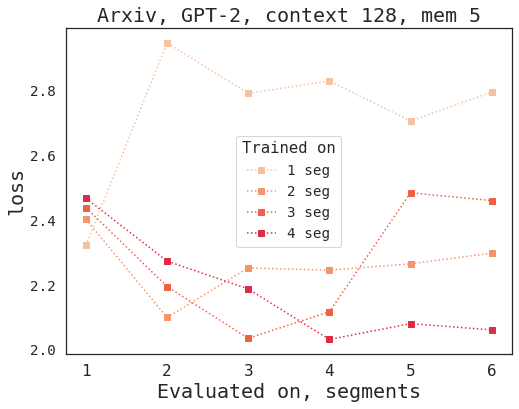

In [27]:
custom_palette = sns.color_palette("rocket_r", n_colors=8)
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))


tab = table[table.columns[:6]].iloc[:7]
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')]# - baseline_score
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments', fontsize=fs)
plt.ylabel('loss', fontsize=fs)
plt.xticks(range(1, len(eval_segments)+1), labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
plt.title('Arxiv, GPT-2, context 128, mem 5', fontsize=fs)

models = [f'{i} seg' for i in list(tab.index)]
plt.legend(models, title='Trained on')
# plt.savefig('img/extrapolate.pdf', format='pdf', bbox_inches='tight')
plt.show()

### wikitext - multiseg

In [443]:
!cd ..;python parse_tb.py

  0%|          | 0/496 [00:00<?, ?it/s]
2023-05-07 20:10:49.843672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-07 20:10:49.843714: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [444]:
res_df = pd.read_csv('../results/wikitext-multiseg.csv')

In [445]:
res_df.num_mem_tokens = res_df.num_mem_tokens.fillna('NA')
res_df.max_n_segments = res_df.max_n_segments.fillna('NA')
# df.share_memory_layers = df.share_memory_layers.fillna(False)
res_df.k2 = res_df.k2.fillna(-1)
res_df['checkpoint_segment'] = res_df.model_path.apply(lambda x: x.split('from_cpt_')[1].split('-')[0] if 'from_cpt_' in x else -1).astype(int)
res_df['eval_segment'] = res_df.max_n_segments
# df['from_cpt'] = (~df.backbone_cpt.isna()).fillna(False)
# df.freeze_model_weights = df.freeze_model_weights.fillna(False)

### extrapolation

In [464]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'segm_valid' in x and ('run_2' in x or 'mem10' in x))].copy()

Text(0, 0.5, 'Valid loss')

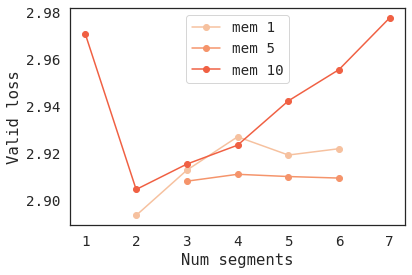

In [465]:
num_tokens = np.unique(df.num_mem_tokens)
for num_mem in num_tokens:
    slc = df[df.num_mem_tokens == num_mem]
    slc = slc[slc.checkpoint_segment == slc.eval_segment].sort_values('checkpoint_segment')
    plt.plot(slc.checkpoint_segment, slc.best_valid_loss, marker='o')
    
plt.legend([f'mem {int(n)}' for n in num_tokens])
plt.xlabel('Num segments')
plt.ylabel('Valid loss')

#### segmented validation mem 5

In [449]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'segm_valid' in x and 'run_1' in x)].copy()
df = df[df.num_mem_tokens == 5]

gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

baseline_score = 2.953460
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table - baseline_score

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                         0.000786  5.240956  6.117512  6.284274  6.347375   
2                         0.092536 -0.056885  0.837013  1.908346  2.579189   
3                         0.114902  0.090783 -0.048290  0.000284  0.219169   
4                         0.160569  0.613973  0.078387 -0.041910  0.012016   
5                         0.183875  4.483671  2.112103  0.031773 -0.022282   
6                         0.183207  6.317534  2.233219  1.076151  0.047572   
7                         0.207037  7.519168  2.898285  3.155314  1.133836   

                                                                      
eval_segment              6         7         8         9         10  
checkpoint_segment                                                    
1                   6.367681  6.380861  6.386282  6.389956  6.391007  
2                   2.514880  2.503755  2.358686  2.285884  2.195533  
3                   0.753012  1.162861  1.475586  1.666424  1.782091  
4                   0.020721  0.024632  0.033421  0.037747  0.043806  
5                   0.035719  0.048383  0.049893  0.048087  0.047432  
6                  -0.021334  0.041760  0.062554  0.065884  0.066004  
7                   0.061890  0.000708  0.067672  0.089600  0.093359

#### segmented validation mem 10

In [450]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'segm_valid' in x and 'run_1' in x)].copy()
df = df[df.num_mem_tokens == 10]

gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])

baseline_score = 2.953460
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table - baseline_score 

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                         0.017031  5.316075  5.761672  5.850764  5.875190   
2                         0.223280 -0.049166  0.690764  1.837431  2.471289   
3                         0.660496  0.256801 -0.038329  0.064743  0.122927   
4                         0.771480  2.727141  0.241103 -0.030258  0.077450   
5                         0.652536  2.571806  2.459379  0.226902 -0.011359   
6                         0.619168  4.395004  4.443750  1.254856  0.189576   
7                         0.526521  4.862644  4.368672  2.254435  1.410561   

                                                                      
eval_segment              6         7         8         9         10  
checkpoint_segment                                                    
1                   5.885937  5.888419  5.888928  5.890251  5.889996  
2                   2.305344  2.553149  2.479140  2.543201  2.498211  
3                   0.414862  0.835361  1.150606  1.399120  1.564290  
4                   0.109023  0.152481  0.214284  0.286584  0.332159  
5                   0.095366  0.112459  0.134259  0.156879  0.166211  
6                   0.002016  0.092093  0.111999  0.116809  0.092531  
7                   0.170122  0.024124  0.107552  0.197584  0.216722

#### segmented validation run 2

In [377]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'segm_valid' in x and 'run_1' in x)].copy()
seg1 = df[df.checkpoint_segment == 1].copy()
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'segm_valid' in x and 'run_2' in x)].copy()
df = pd.concat((df, seg1))

In [378]:
# df = pd.concat(df, res_df

In [379]:
gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
# group_df

In [380]:
# table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
# table

In [381]:
baseline_score = 2.953460
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table - baseline_score 

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                        -0.008798  5.218863  5.758703  5.743047  5.707946   
2                         0.013564 -0.060241  0.020755  1.009615  1.278761   
3                         0.030341 -0.044586 -0.040917 -0.032559  0.088063   
4                         0.027879 -0.013891 -0.027874 -0.026687 -0.027281   
5                         0.031603 -0.032962 -0.032082 -0.034039 -0.034472   
6                         0.036607 -0.031358 -0.028739 -0.030962 -0.031641   

                                                                      
eval_segment              6         7         8         9         10  
checkpoint_segment                                                    
1                   5.691786  5.687142  5.684877  5.683396  5.682353  
2                   1.259507  1.319373  1.302102  1.322368  1.316135  
3                   0.139166  0.249414  0.329995  0.435976  0.523455  
4                  -0.027712 -0.027730 -0.027750 -0.027742 -0.027751  
5                  -0.034545 -0.034566 -0.034565 -0.034567 -0.034567  
6                  -0.031765 -0.031762 -0.031765 -0.031765 -0.031765

#### segmented validation run 1

In [383]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'segm_valid' in x and 'run_1' in x)].copy()


In [384]:
gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
# group_df

In [387]:
# table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
# table

In [386]:
baseline_score = 2.953460
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table - baseline_score 

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                        -0.008798  5.218863  5.758703  5.743047  5.707946   
2                         0.012470 -0.061500  0.019545  1.009203  1.279158   
3                         0.019572 -0.038069 -0.033884 -0.010757  0.188753   
4                         0.025727 -0.025838 -0.026674 -0.025733 -0.026053   
5                         0.028103 -0.029862 -0.028878 -0.029711 -0.029498   
6                         0.028103 -0.029862 -0.028878 -0.029711 -0.029498   

                                                                      
eval_segment              6         7         8         9         10  
checkpoint_segment                                                    
1                   5.691786  5.687142  5.684877  5.683396  5.682353  
2                   1.260668  1.318112  1.301867  1.320214  1.313629  
3                   0.334932  0.477607  0.582409  0.685644       NaN  
4                  -0.026302 -0.026357 -0.026370 -0.026373       NaN  
5                  -0.029733 -0.029778 -0.029795       NaN       NaN  
6                  -0.029733 -0.029778 -0.029795       NaN       NaN

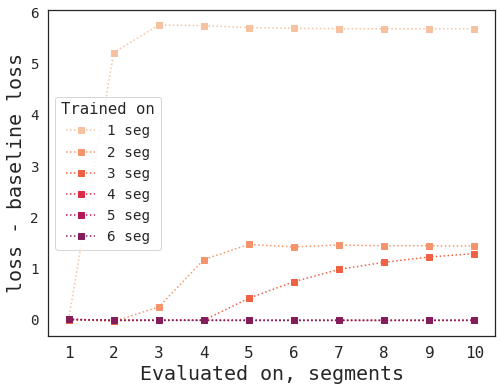

In [350]:
custom_palette = sns.color_palette("rocket_r", n_colors=8)
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))


# tab = table[table.columns[:15]].iloc[:7]
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')] - baseline_score
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments', fontsize=fs)
plt.ylabel('loss - baseline loss', fontsize=fs)
plt.xticks(range(1, len(eval_segments)+1), labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
# plt.title('Memorization', fontsize=fs)

models = [f'{i} seg' for i in list(tab.index)]
plt.legend(models, title='Trained on')
# plt.savefig('img/extrapolate.pdf', format='pdf', bbox_inches='tight')
plt.show()

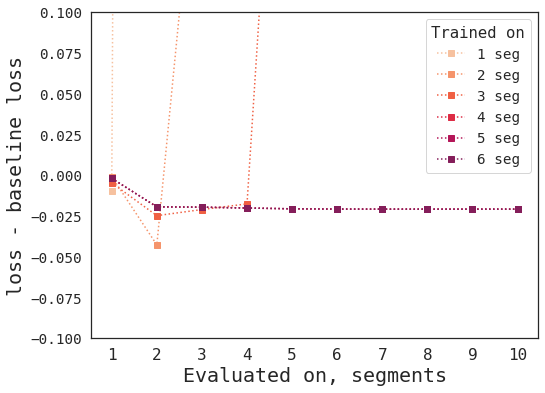

In [351]:
custom_palette = sns.color_palette("rocket_r", n_colors=8)
sns.set_theme(style='white', palette=custom_palette, font_scale=1.3, font='monospace')

fs = 20
plt.figure(figsize=(8,6))


# tab = table[table.columns[:15]].iloc[:7]
for train_seg in list(tab.index):
    row = tab.loc[train_seg].loc[('best_valid_loss')] - baseline_score
    eval_segments, scores = row.index, row.values
    plt.plot(eval_segments, scores, marker='s', linestyle='dotted')

plt.xlabel('Evaluated on, segments', fontsize=fs)
plt.ylabel('loss - baseline loss', fontsize=fs)
plt.xticks(range(1, len(eval_segments)+1), labels=eval_segments, fontsize=fs*0.8)
# plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
# plt.title('Memorization', fontsize=fs)
plt.ylim(-0.1, 0.1)

models = [f'{i} seg' for i in list(tab.index)]
plt.legend(models, title='Trained on')
# plt.savefig('img/extrapolate.pdf', format='pdf', bbox_inches='tight')
plt.show()

#### continuous validation

In [276]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' in x and 'chunked' in x)].copy()
df['checkpoint_segment'] = df.model_path.apply(lambda x: x.split('from_cpt_')[1].split('-')[0]).astype(int)
df['eval_segment'] = df.max_n_segments

In [277]:
gb_cols = ['input_size', 'checkpoint_segment', 'num_mem_tokens', 'eval_segment']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
# group_df

In [278]:
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                         2.944067  8.172538  8.713217  8.698071  8.663234   
2                         2.952558  2.910761  3.194788  4.122667  4.418456   
3                         2.948757  2.928664  2.932415  2.935880  3.366055   
4                         2.951539  2.934062  2.933879  2.933349  2.932859   
5                         2.951539  2.934062  2.933879  2.933349  2.932859   
6                         2.951539  2.934062  2.933879  2.933349  2.932859   

                                                                      
eval_segment              6         7         8         9         10  
checkpoint_segment                                                    
1                   8.646637  8.642073  8.639933  8.638370  8.637287  
2                   4.370034  4.406917  4.391923  4.391372  4.387811  
3                   3.690738  3.929178  4.069761  4.172633  4.238768  
4                   2.932715  2.932674  2.932668  2.932667  2.932667  
5                   2.932715  2.932674  2.932668  2.932667  2.932667  
6                   2.932715  2.932674  2.932668  2.932667  2.932667

In [279]:
baseline_score = 2.953460
table = pd.pivot_table(group_df, index=['checkpoint_segment'], columns=['eval_segment'], values=['best_valid_loss'])
table - baseline_score 

best_valid_loss                                          \
eval_segment                    1         2         3         4         5    
checkpoint_segment                                                           
1                        -0.009393  5.219078  5.759757  5.744611  5.709774   
2                        -0.000902 -0.042699  0.241328  1.169207  1.464996   
3                        -0.004703 -0.024796 -0.021045 -0.017580  0.412595   
4                        -0.001921 -0.019398 -0.019581 -0.020111 -0.020601   
5                        -0.001921 -0.019398 -0.019581 -0.020111 -0.020601   
6                        -0.001921 -0.019398 -0.019581 -0.020111 -0.020601   

                                                                      
eval_segment              6         7         8         9         10  
checkpoint_segment                                                    
1                   5.693177  5.688613  5.686473  5.684910  5.683827  
2                   1.416574  1.453457  1.438463  1.437912  1.434351  
3                   0.737278  0.975718  1.116301  1.219173  1.285308  
4                  -0.020745 -0.020786 -0.020792 -0.020793 -0.020793  
5                  -0.020745 -0.020786 -0.020792 -0.020793 -0.020793  
6                  -0.020745 -0.020786 -0.020792 -0.020793 -0.020793

<Figure size 576x432 with 0 Axes>

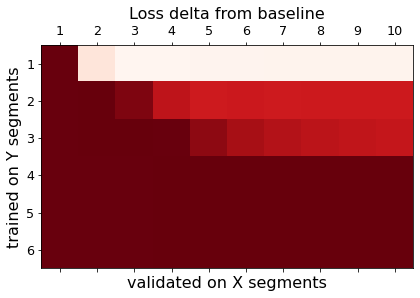

In [280]:
fs = 16
plt.figure(figsize=(8,6))
tab = table[table.columns[:15]].iloc[:7]
plt.matshow((table - baseline_score).values, cmap='Reds_r')
plt.xlabel('validated on X segments', fontsize=fs)
plt.ylabel('trained on Y segments', fontsize=fs)
plt.xticks(range(tab.shape[1]), labels=list(map(lambda x: x[1], tab.columns)), fontsize=fs*0.8)
plt.yticks(range(tab.shape[0]), labels=tab.index, fontsize=fs*0.8)
plt.title('Loss delta from baseline', fontsize=fs)
# plt.savefig('img/extrapolate_hm.pdf', format='pdf')
plt.show()

### curriculum

In [182]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' not in x and 'from_cpt' in x)].copy()

In [183]:
df['chunked'] = df.model_path.apply(lambda x: 'chunked' in x)

In [184]:
gb_cols = ['input_size', 'max_n_segments', 'chunked', 'num_mem_tokens', 'lr', 'lr_scheduler',]
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_loss  \
input_size max_n_segments chunked num_mem_tokens lr      lr_scheduler                    
128        1              False   1.0            0.00005 linear               2.945818   
           2              False   1.0            0.00005 linear               4.366513   
                          True    1.0            0.00001 linear               4.395957   
           3              False   1.0            0.00005 linear               3.020203   
                          True    1.0            0.00001 linear               4.358905   
           4              False   1.0            0.00005 linear               2.997787   
                          True    1.0            0.00001 linear               2.954910   
           5              False   1.0            0.00005 linear               3.004885   
                          True    1.0            0.00001 linear               2.954769   
           6              False   1.0            0.00005 linear               3.004962   
                          True    1.0            0.00001 linear               2.954784   
           7              False   1.0            0.00005 linear               3.008343   
                          True    1.0            0.00001 linear               2.955649   
           8              False   1.0            0.00005 linear               3.008343   

                                                                            std  \
input_size max_n_segments chunked num_mem_tokens lr      lr_scheduler             
128        1              False   1.0            0.00005 linear        0.000173   
           2              False   1.0            0.00005 linear             NaN   
                          True    1.0            0.00001 linear             NaN   
           3              False   1.0            0.00005 linear             NaN   
                          True    1.0            0.00001 linear             NaN   
           4              False   1.0            0.00005 linear             NaN   
                          True    1.0            0.00001 linear             NaN   
           5              False   1.0            0.00005 linear        0.000000   
                          True    1.0            0.00001 linear             NaN   
           6              False   1.0            0.00005 linear             NaN   
                          True    1.0            0.00001 linear             NaN   
           7              False   1.0            0.00005 linear             NaN   
                          True    1.0            0.00001 linear             NaN   
           8              False   1.0            0.00005 linear             NaN   

                                                                       n_runs  \
input_size max_n_segments chunked num_mem_tokens lr      lr_scheduler           
128        1              False   1.0            0.00005 linear             3   
           2              False   1.0            0.00005 linear             1   
                          True    1.0            0.00001 linear             1   
           3              False   1.0            0.00005 linear             1   
                          True    1.0            0.00001 linear             1   
           4              False   1.0            0.00005 linear             1   
                          True    1.0            0.00001 linear             1   
           5              False   1.0            0.00005 linear             2   
                          True    1.0            0.00001 linear             1   
           6              False   1.0            0.00005 linear             1   
                          True    1.0            0.00001 linear             1   
           7              False   1.0            0.00005 linear             1   
                          True    1.0            0.00001 linear             1   
           8              False   1.0            0.00005 linear             1   

    

### vanilla

In [172]:
df = res_df[res_df.model_path.apply(lambda x: 'eval' not in x and 'from_cpt' not in x)]

In [173]:
df = df[df.num_steps > 9000]

In [174]:
gb_cols = ['input_size', 'max_n_segments', 'num_mem_tokens', 'lr', 'lr_scheduler',]
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).min()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_loss  \
input_size max_n_segments num_mem_tokens lr      lr_scheduler                    
64         2              1.0            0.00005 linear               5.834481   
                          5.0            0.00005 linear               5.084059   
                          10.0           0.00005 linear               5.978330   
           3              1.0            0.00005 linear               3.196006   
                          5.0            0.00005 linear               3.258076   
                          10.0           0.00005 linear               3.344816   
           4              1.0            0.00005 linear               3.258616   
                          5.0            0.00005 linear               3.224445   
                          10.0           0.00005 linear               3.346584   
           5              1.0            0.00005 linear               3.255840   
                          5.0            0.00005 linear               3.324244   
128        1              1.0            0.00005 linear               2.947527   
                          5.0            0.00005 linear               2.960443   
                          10.0           0.00005 linear               2.976584   
                          NA             0.00005 linear               2.953460   
           2              1.0            0.00005 linear               4.380685   
                          5.0            0.00005 linear               3.526484   
                          10.0           0.00005 linear               4.289703   
           3              1.0            0.00005 linear               3.002402   
                          5.0            0.00005 linear               3.033959   
                          10.0           0.00005 linear               3.075089   
           4              1.0            0.00005 linear               3.016222   
                          5.0            0.00005 linear               3.031811   
                          10.0           0.00005 linear               3.038059   
           5              1.0            0.00005 linear               3.038116   
                          5.0            0.00005 linear               3.080352   
                          10.0           0.00005 linear               3.067651   
           6              1.0            0.00005 linear               3.020492   
256        1              1.0            0.00001 linear               2.825476   
                                         0.00005 linear               2.832754   
                                         0.00008 linear               2.841326   
                          5.0            0.00001 linear               2.833221   
                                         0.00005 linear               2.839976   
                                         0.00008 linear               2.849988   
                          10.0           0.00001 linear               2.839963   
                                         0.00005 linear               2.840628   
                                         0.00008 linear               2.852742   
                          NA             0.00001 linear               2.829825   
                                         0.00005 linear               2.836491   
           2              1.0            0.00001 linear               3.687324   
                                         0.00005 linear               3.688727   
                                         0.00008 linear               3.716200   
                          5.0            0.00001 linear               3.578869   
                                         0.00005 linear               3.601228   
                                         0.00008 linear               3.487755   
                          10.0           0.00001 linear               4.167626   
                                         0.00005 linear               3.826776   
                                         0.00

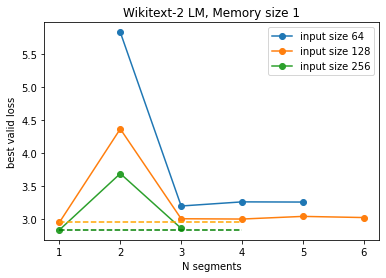

In [104]:
input_sizes = np.unique(df.input_size)
for input_size in input_sizes:
    mask = (df.input_size == input_size) & (df.lr ==0.00005) & (df.num_mem_tokens == 1)
    slc = df[mask]
    
    gb_cols = ['max_n_segments']

    group_df = slc.groupby(gb_cols).min()[metric_cols]
    
    plt.plot(group_df.index, group_df.values, marker='o')
    
plt.hlines(2.953460, 1, 4, linestyle='dashed', color='orange')
plt.hlines(2.836491, 1, 4, linestyle='dashed', color='green')

plt.title('Wikitext-2 LM, Memory size 1')
plt.xlabel('N segments')
plt.ylabel('best valid loss')
plt.legend([f'input size {s}' for s in input_sizes])
plt.xticks(np.unique(df.max_n_segments))
plt.show()

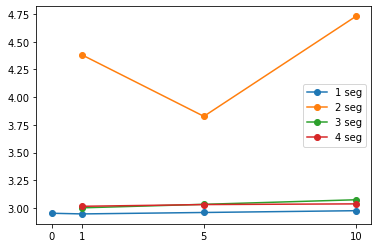

In [74]:
segment_sizes = np.unique(df.max_n_segments)
for n_seg in segment_sizes:
    mask = (df.input_size == 128) & (df.lr ==0.00005) & (df.max_n_segments == n_seg)
    slc = df[mask].copy()
    slc.loc[slc.num_mem_tokens == 'NA', 'num_mem_tokens'] = 0
    
    gb_cols = ['num_mem_tokens']

    group_df = slc.groupby(gb_cols).min()[metric_cols]
    
    plt.plot(group_df.index, group_df.values, marker='o')
    

# plt.title('Wikitext-2 LM, Memory size 1')
# plt.xlabel('N segments')
# plt.ylabel('best valid loss')
plt.legend([f'{s} seg' for s in segment_sizes])
plt.xticks([0, 1, 5, 10])
plt.show()

### wikitext

In [96]:
!cd ..;python parse_tb.py

  0%|          | 0/41 [00:00<?, ?it/s]
2023-04-06 12:34:16.453394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-06 12:34:16.453468: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [88]:
df = pd.read_csv('../results/wikitext.csv')

In [93]:
df.num_mem_tokens = df.num_mem_tokens.fillna('NA')
df.share_memory_layers = df.share_memory_layers.fillna(False)
df.k2 = df.k2.fillna(1)
df['from_cpt'] = (~df.backbone_cpt.isna()).fillna(False)
df.freeze_model_weights = df.freeze_model_weights.fillna(False)

In [94]:
df = df[df.best_valid_loss < 3]

In [95]:
gb_cols = ['from_pretrained', 'model_cls', 'num_mem_tokens', 'lr', 'lr_scheduler', 'k2', 'freeze_model_weights', 'from_cpt']
metric_cols = ['best_valid_loss']
group_df = df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_loss  \
from_pretrained model_cls                                          num_mem_tokens lr       lr_scheduler         k2   freeze_model_weights from_cpt                    
gpt2            modeling_rmt.language_modeling:RMTDecoderLMHead    10.0           0.000005 linear                1.0 False                False            2.696082   
                                                                   25.0           0.000005 constant_with_warmup  1.0 False                False            2.693921   
                                                                                                                 2.0 False                False            2.693101   
                                                                                           linear                1.0 False                False            2.700119   
                                                                                                                 2.0 False                False            2.697857   
                modeling_rmt.language_modeling:RMTDecoderMemory... 10.0           0.000001 linear                1.0 False                False            2.857818   
                                                                                                                 2.0 False                False            2.839722   
                                                                                  0.000005 linear                1.0 False                False            2.724896   
                                                                                                                 2.0 False                False            2.709527   
                                                                                  0.000010 constant_with_warmup  1.0 True                 True             2.764399   
                                                                                           linear                1.0 False                False            2.698679   
                                                                                                                                          True             2.695399   
                                                                                                                 2.0 False                False            2.684810   
                                                                                  0.000100 constant_with_warmup  1.0 True                 True             2.783597   
                modeling_rmt:RMTDecoderForCausalLM                 10.0           0.000005 constant_with_warmup  1.0 False                False            2.692568   
                                                                                                                 2.0 False                False            2.688242   
                                                                                                                 3.0 False                False            2.688129   
                                                                                  0.000010 constant_with_warmup  1.0 False                False            2.696101   
                                                                                           linear                1.0 False                False            2.707594   
                                                                                  0.000050 constant_with_warmup  1.0 False                False            2.706325   
                                                                                  0.000100 constant_with_warmup  1.0 False                False            2.719023   
                                                                   25.0           0.000010 linear                1.0 False                False            2.833547   
                                                                   50.0           0.000005 constant_with_warmup  1.0 False                Fa

### qmsum

In [348]:
!cd ..;python parse_tb.py

  0%|          | 0/1913 [00:00<?, ?it/s]


In [19]:
# res_df = pd.read_csv('../results/qmsum.csv')

In [ ]:
res_df.input_seg_size = res_df.input_seg_size.fillna(512)
res_df = res_df[res_df.num_steps.isin({3200})]
res_df.fillna('UNKNOWN', inplace=True)

In [ ]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler', 'sum_loss', 'segment_ordering']
metric_cols = ['best_valid_rouge/geometric_mean']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[metric_cols]
group_df['n_runs'] = res_df.groupby(gb_cols).count()[metric_cols]
group_df['runs'] = res_df.groupby(gb_cols).agg({metric_cols[0]:tuple})[metric_cols[0]].apply(lambda x: [round(i,2) for i in x])
group_df

In [37]:
# group_df.sort_values('best_valid_rouge/geometric_mean')

### quality

In [603]:
!cd ..;python parse_tb.py

  0%|          | 0/1630 [00:00<?, ?it/s]


In [45]:
# res_df = pd.read_csv('../results/quality.csv')
paths = [
        '../results/quality.csv',
        '../results/quality_new.csv'
        ]
         

In [46]:
res_df = pd.concat([pd.read_csv(p) for p in paths])
res_df.input_seg_size = res_df.input_seg_size.fillna(512)
# res_df.padding_side = res_df.padding_side.fillna('left')
# res_df = res_df[res_df.num_steps.isin({3200})]
res_df.fillna('UNKNOWN', inplace=True)
res_df = res_df[res_df.num_steps.isin({'UNKNOWN', 3200, 1600})]

In [47]:
# res_df = res_df[res_df.best_valid_exact_match > 1]

In [48]:
gb_cols = ['from_pretrained', 'input_seg_size', 'input_seq_len', 'num_mem_tokens', 'lr', 'lr_scheduler', 'sum_loss', 'segment_ordering' ]
metric_cols = ['best_valid_exact_match']
group_df = res_df.groupby(gb_cols).mean()[metric_cols]
group_df['std'] = res_df.groupby(gb_cols).std()[['best_valid_exact_match']]
group_df['n_runs'] = res_df.groupby(gb_cols).count()['best_valid_exact_match']
group_df['runs'] = res_df.groupby(gb_cols).agg({'best_valid_exact_match':tuple}).best_valid_exact_match.apply(lambda x: [round(i,2) for i in x])
group_df

best_valid_exact_match  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering                           
t5-base         512.0          512           UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                        31.208099   
                               984           25.0           0.00020 linear       True     bidirectional                  21.524450   
                                                                                          regular                         0.000000   
                               998           10.0           0.00005 linear       UNKNOWN  UNKNOWN                        28.395667   
                                                            0.00010 linear       UNKNOWN  UNKNOWN                        30.021550   
                               1002          10.0           0.00020 linear       False    regular                         0.023950   
                                                                                          repeat_first                   28.799150   
                                                                                 True     bidirectional                  28.811151   
                               1024          UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                        32.454498   
                               1503          10.0           0.00020 linear       True     bidirectional                  24.017300   
                                                                                          regular                         0.000000   
                                                                                          repeat_first                   27.468800   

                                                                                                                 std  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering             
t5-base         512.0          512           UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                NaN   
                               984           25.0           0.00020 linear       True     bidirectional     1.559242   
                                                                                          regular           0.000000   
                               998           10.0           0.00005 linear       UNKNOWN  UNKNOWN           0.508137   
                                                            0.00010 linear       UNKNOWN  UNKNOWN           0.167795   
                               1002          10.0           0.00020 linear       False    regular           0.026236   
                                                                                          repeat_first      0.638873   
                                                                                 True     bidirectional     0.813526   
                               1024          UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                NaN   
                               1503          10.0           0.00020 linear       True     bidirectional          NaN   
                                                                                          regular           0.000000   
                                                                                          repeat_first           NaN   

                                                                                                            n_runs  \
from_pretrained input_seg_size input_seq_len num_mem_tokens lr      lr_scheduler sum_loss segment_ordering           
t5-base         512.0          512           UNKNOWN        0.00020 linear       UNKNOWN  UNKNOWN                1   
                               984           25.0           0.00020 linear       True     bidirectional          2   
                                                                              